Much like individual classification estimators to form an ensemble of estimators, here goal is to explore ensembles for regression models.  

Below, a dataset containing census information on individuals and their hourly wage is loaded using the `fetch_openml` function.  OpenML is another repository for datasets [here](https://www.openml.org/).  

Task is to use ensemble methods to explore predicting the `wage` column of the data with the following models:

- `LinearRegression` -- perhaps you even want the `TransformedTargetRegressor` here.
- `KNeighborsRegressor`
- `DecisionTreeRegressor`
- `Ridge`
- `SVR`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Load dataset
survey = fetch_openml(data_id=534, as_frame=True).frame



In [2]:
# Change feature names to lowercase
survey.columns = survey.columns.str.lower()

# Check for missing values
print(survey.isnull().sum())

# Drop rows with missing values
survey.dropna(inplace=True)

# Separate features and target variable
X = survey.drop(columns=['wage'])
y = survey['wage']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

education     0
south         0
sex           0
experience    0
union         0
wage          0
age           0
race          0
occupation    0
sector        0
marr          0
dtype: int64


In [3]:

# Define individual regressors
linear_reg = LinearRegression()
knn_reg = KNeighborsRegressor()
tree_reg = DecisionTreeRegressor(random_state=42)
ridge_reg = Ridge()
svr_reg = SVR()

# Create pipelines for each regressor
pipelines = {
    'linear': Pipeline([('scaler', StandardScaler()), ('regressor', linear_reg)]),
    'knn': Pipeline([('scaler', StandardScaler()), ('regressor', knn_reg)]),
    'tree': Pipeline([('regressor', tree_reg)]),
    'ridge': Pipeline([('scaler', StandardScaler()), ('regressor', ridge_reg)]),
    'svr': Pipeline([('scaler', StandardScaler()), ('regressor', svr_reg)])
}

# Define the Voting Regressor
voting_reg = VotingRegressor(estimators=[
    ('linear', pipelines['linear']),
    ('knn', pipelines['knn']),
    ('tree', pipelines['tree']),
    ('ridge', pipelines['ridge']),
    ('svr', pipelines['svr'])
])


In [5]:

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Evaluate individual models without grid search
results_before_gs = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    mse = evaluate_model(pipeline, X_test, y_test)
    results_before_gs[name] = mse

results_before_gs

{'linear': 19.50259732411234,
 'knn': 22.875903850467285,
 'tree': 59.54706869158879,
 'ridge': 19.495888447445072,
 'svr': 21.70955180758242}

In [ ]:

# Evaluate Voting Regressor without grid search
voting_reg.fit(X_train, y_train)
voting_mse_before_gs = evaluate_model(voting_reg, X_test, y_test)
results_before_gs['voting'] = voting_mse_before_gs

results_before_gs

{'linear': 19.50259732411234,
 'knn': 22.875903850467285,
 'tree': 59.54706869158879,
 'ridge': 19.495888447445072,
 'svr': 21.70955180758242,
 'voting': 21.537930170531695}

In [7]:
# Print results before grid search
print("Results Before Grid Search:")
for name, mse in results_before_gs.items():
    print(f'{name}: MSE = {mse}')


Results Before Grid Search:
linear: MSE = 19.50259732411234
knn: MSE = 22.875903850467285
tree: MSE = 59.54706869158879
ridge: MSE = 19.495888447445072
svr: MSE = 21.70955180758242
voting: MSE = 21.537930170531695


In [8]:

# Define parameter grids for Grid Search
param_grids = {
    'linear': {},
    'knn': {'regressor__n_neighbors': [3, 5, 7]},
    'tree': {'regressor__max_depth': [3, 5, 7]},
    'ridge': {'regressor__alpha': [0.1, 1.0, 10.0]},
    'svr': {'regressor__C': [0.1, 1.0, 10.0], 'regressor__gamma': ['scale', 'auto']}
}

# Perform Grid Search and evaluate models
results_after_gs = {}
best_pipelines = {}

for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_pipeline = grid_search.best_estimator_
    best_pipelines[name] = best_pipeline
    mse = evaluate_model(best_pipeline, X_test, y_test)
    results_after_gs[name] = mse

# Define the optimized Voting Regressor
optimized_voting_reg = VotingRegressor(estimators=[
    ('linear', best_pipelines['linear']),
    ('knn', best_pipelines['knn']),
    ('tree', best_pipelines['tree']),
    ('ridge', best_pipelines['ridge']),
    ('svr', best_pipelines['svr'])
])

# Fit the optimized Voting Regressor
optimized_voting_reg.fit(X_train, y_train)
voting_mse_after_gs = evaluate_model(optimized_voting_reg, X_test, y_test)
results_after_gs['voting'] = voting_mse_after_gs

# Print results after grid search
print("\nResults After Grid Search:")
for name, mse in results_after_gs.items():
    print(f'{name}: MSE = {mse}')



Results After Grid Search:
linear: MSE = 19.50259732411234
knn: MSE = 21.052861815754337
tree: MSE = 22.469790483538922
ridge: MSE = 19.56878914773628
svr: MSE = 21.70955180758242
voting: MSE = 19.568476739370826


In [10]:

# Feature importance from Decision Tree
tree_reg.fit(X_train, y_train)
importances_tree = tree_reg.feature_importances_
feature_importance_tree_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances_tree})
feature_importance_tree_df = feature_importance_tree_df.sort_values(by='importance', ascending=False)
print("\nFeature Importance from Decision Tree:")
print(feature_importance_tree_df)



Feature Importance from Decision Tree:
                    feature  importance
1                experience    0.288039
0                 education    0.197098
2                       age    0.163294
8     occupation_Management    0.048567
5          union_not_member    0.045611
12       occupation_Service    0.041825
4                  sex_male    0.041818
3                 south_yes    0.035883
13     sector_Manufacturing    0.027274
15           marr_Unmarried    0.023815
6                race_Other    0.020453
7                race_White    0.016237
10  occupation_Professional    0.015194
11         occupation_Sales    0.013781
14             sector_Other    0.011247
9          occupation_Other    0.009866


In [11]:

# Coefficients from Linear regression
linear_reg.fit(X_train, y_train)
coefficients_linear = linear_reg.coef_
coefficients_linear_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': coefficients_linear})
coefficients_linear_df = coefficients_linear_df.sort_values(by='coefficient', ascending=False)
print("\nCoefficients from Linear Regression:")
print(coefficients_linear_df)



Coefficients from Linear Regression:
                    feature  coefficient
8     occupation_Management     3.082299
4                  sex_male     1.763136
10  occupation_Professional     1.710179
7                race_White     0.838962
0                 education     0.830298
13     sector_Manufacturing     0.803927
1                experience     0.370279
6                race_Other     0.025422
9          occupation_Other    -0.067962
15           marr_Unmarried    -0.238529
2                       age    -0.284679
14             sector_Other    -0.368954
3                 south_yes    -0.423335
11         occupation_Sales    -0.497844
12       occupation_Service    -0.766262
5          union_not_member    -2.168736


In [12]:

# Coefficients from Ridge regression
ridge_reg.fit(X_train, y_train)
coefficients_ridge = ridge_reg.coef_
coefficients_ridge_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': coefficients_ridge})
coefficients_ridge_df = coefficients_ridge_df.sort_values(by='coefficient', ascending=False)
print("\nCoefficients from Ridge Regression:")
print(coefficients_ridge_df)



Coefficients from Ridge Regression:
                    feature  coefficient
8     occupation_Management     2.969867
4                  sex_male     1.754821
10  occupation_Professional     1.646448
7                race_White     0.789732
13     sector_Manufacturing     0.762019
0                 education     0.761107
1                experience     0.293783
6                race_Other    -0.018889
9          occupation_Other    -0.078171
2                       age    -0.207689
15           marr_Unmarried    -0.238593
14             sector_Other    -0.397740
3                 south_yes    -0.425641
11         occupation_Sales    -0.516526
12       occupation_Service    -0.776785
5          union_not_member    -2.125914


In [13]:

# Feature importance using permutation for KNN
result_knn = permutation_importance(best_pipelines['knn'], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_knn = pd.DataFrame({'feature': X_test.columns, 'importance': result_knn.importances_mean})
perm_importances_knn = perm_importances_knn.sort_values(by='importance', ascending=False)
print("\nPermutation Importance from KNN:")
print(perm_importances_knn)



Permutation Importance from KNN:
                    feature  importance
8     occupation_Management    0.147742
10  occupation_Professional    0.139424
0                 education    0.135802
13     sector_Manufacturing    0.048437
4                  sex_male    0.044251
2                       age    0.041648
11         occupation_Sales    0.030054
15           marr_Unmarried    0.029417
1                experience    0.023796
12       occupation_Service    0.017148
3                 south_yes    0.015523
14             sector_Other    0.005665
5          union_not_member   -0.002970
6                race_Other   -0.006204
9          occupation_Other   -0.006350
7                race_White   -0.010207


In [14]:

# Feature importance using permutation for SVR
result_svr = permutation_importance(best_pipelines['svr'], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_svr = pd.DataFrame({'feature': X_test.columns, 'importance': result_svr.importances_mean})
perm_importances_svr = perm_importances_svr.sort_values(by='importance', ascending=False)
print("\nPermutation Importance from SVR:")
print(perm_importances_svr)




Permutation Importance from SVR:
                    feature  importance
0                 education    0.130586
8     occupation_Management    0.061015
10  occupation_Professional    0.057546
4                  sex_male    0.048359
12       occupation_Service    0.029545
9          occupation_Other    0.024581
2                       age    0.017613
5          union_not_member    0.014985
13     sector_Manufacturing    0.014360
14             sector_Other    0.011268
3                 south_yes    0.008949
11         occupation_Sales    0.008346
7                race_White    0.007188
6                race_Other    0.006501
15           marr_Unmarried    0.005796
1                experience    0.004907


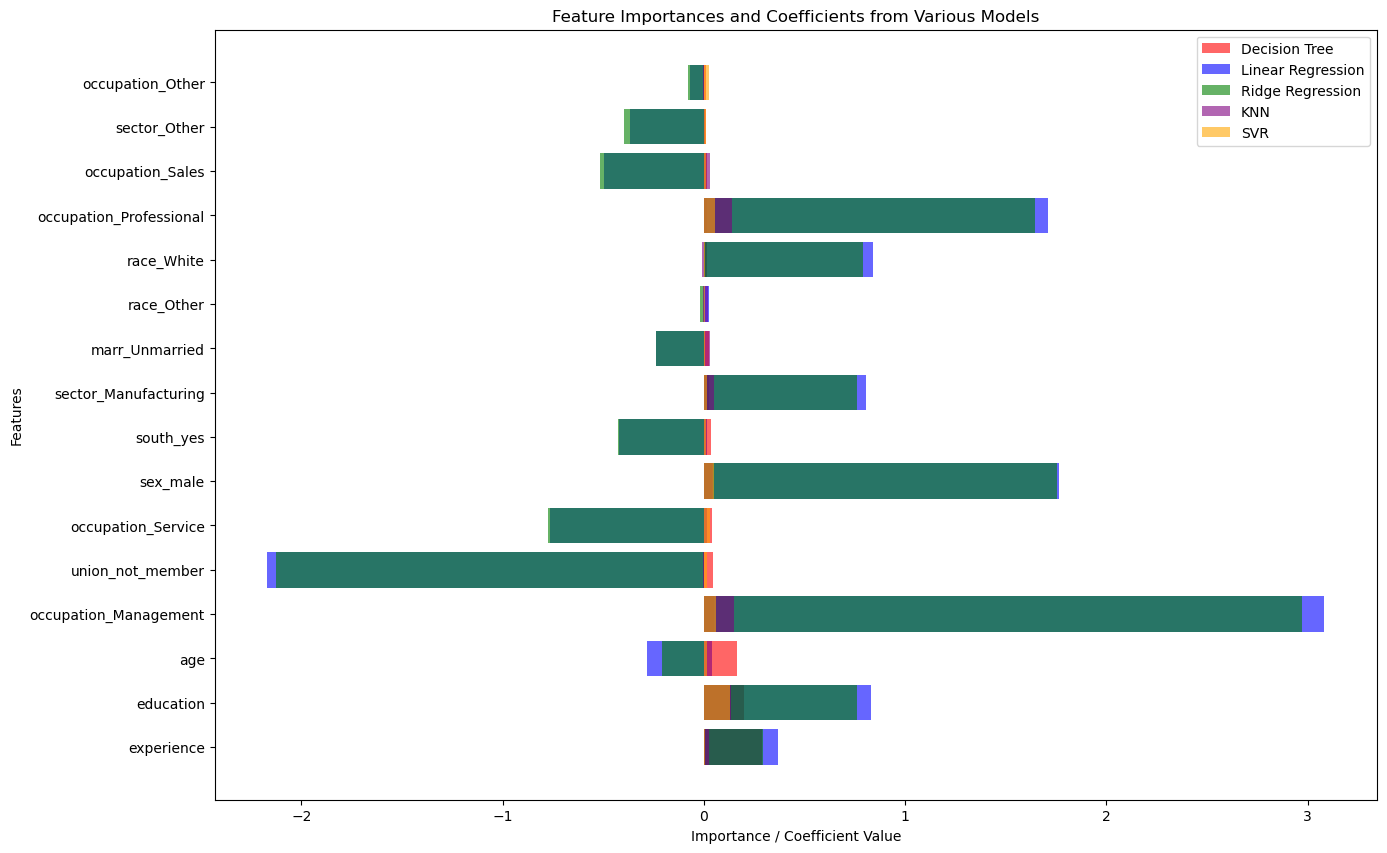

Exception ignored in: <function ResourceTracker.__del__ at 0x7b8c53782020>
Traceback (most recent call last):
  File "/home/vinny/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/vinny/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/vinny/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x78de9a792020>
Traceback (most recent call last):
  File "/home/vinny/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/vinny/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/vinny/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ 

In [15]:
# Plotting the feature importances and coefficients
plt.figure(figsize=(15, 10))

# Plot Decision Tree feature importance
plt.barh(feature_importance_tree_df['feature'], feature_importance_tree_df['importance'], color='red', alpha=0.6, label='Decision Tree')

# Plot Linear Regression coefficients
plt.barh(coefficients_linear_df['feature'], coefficients_linear_df['coefficient'], color='blue', alpha=0.6, label='Linear Regression')

# Plot Ridge Regression coefficients
plt.barh(coefficients_ridge_df['feature'], coefficients_ridge_df['coefficient'], color='green', alpha=0.6, label='Ridge Regression')

# Plot KNN permutation importance
plt.barh(perm_importances_knn['feature'], perm_importances_knn['importance'], color='purple', alpha=0.6, label='KNN')

# Plot SVR permutation importance
plt.barh(perm_importances_svr['feature'], perm_importances_svr['importance'], color='orange', alpha=0.6, label='SVR')

plt.xlabel('Importance / Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances and Coefficients from Various Models')
plt.legend()
plt.show()

## Findings

### Did the “wisdom of the crowd” help?

Before tuning, the best individual models were Ridge and Linear Regression, with MSE around 19.50, while the initial VotingRegressor performed worse, with MSE ≈ 21.54. After hyperparameter tuning, the VotingRegressor improved substantially to an MSE of 19.57, now matching Ridge and coming very close to the best Linear model (MSE 19.50). This suggests that in this setting, the ensemble only **slightly** benefits from the “wisdom of the crowd,” and does not clearly outperform the best single model; instead, it roughly ties the strongest linear baseline. [github](https://github.com/mgesteban/wage-prediction-wisdom-of-the-crowd/blob/main/README.md)

### Model performance summary

- Best individual model (after tuning): Linear Regression with MSE = 19.50  
- Next-best: Ridge Regression with MSE ≈ 19.57  
- Tuned VotingRegressor: MSE ≈ 19.57 (better than tuned KNN and Tree, comparable to Ridge, slightly worse than Linear)  
- Tree and KNN improve a lot after tuning (Tree MSE drops from ~59.55 to ~22.47; KNN from ~22.88 to ~21.05), but still do not beat the linear models or the ensemble.

So, the ensemble does **outperform most individual models (KNN, Tree, SVR)**, but it does **not clearly beat** the best linear model in this particular wage-prediction task. This aligns with the general observation that ensembles often help, but they are not guaranteed to be better than the single best model. [geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/voting-regressor/)

### Interpretability and important features

Even if the VotingRegressor is a “black-box” combination of models, we can use the underlying models to interpret which features matter for wages:

- **Decision Tree feature importance** highlights experience, education, and age as the most important predictors, with some additional importance from occupation, union membership, sex, region (south), and sector.  
- **Linear and Ridge coefficients** show that, holding other variables constant:  
  - Management and professional occupations, being male, being White, higher education, and working in manufacturing are associated with higher wages (positive coefficients).  
  - Being non-union, living in the South, some occupations (Sales, Service), and some sectors (Other) are associated with lower wages (negative coefficients).  
- **Permutation importance for KNN and SVR** consistently emphasizes education, occupation (especially management and professional roles), sex, and sector as key drivers of wage predictions.

Because multiple models agree on the same important features (education, experience/age, occupation, union status, sex, and sector), we can say that these variables are robustly influential, even though the VotingRegressor itself doesn’t yield direct feature importance. This combination of tree-based importance, linear coefficients, and permutation importance provides an interpretable view of what drives wages in the ensemble setting. [openml](https://www.openml.org/d/534)